In [ ]:
# Torch imports
import torch
from torchvision.transforms import v2

# File reading
import os
import pickle
from glob import glob

# Utils
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt

# 1. Global Annotations File 

In [19]:
# Annotations structure
file = './datasets/with-augmentations/Room1/Setting1/episode_0001/episode_0001.pkl'
with open(file, 'rb') as f:
    df = pickle.load(f)
    display(df.head())

,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,robot_1_rel_pos_y,robot_1_in_fov,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,-1.423542,True,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,-2.282922,True,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,-3.499867,True,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,-4.512129,False,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,-4.921282,False,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [ ]:
# Filter warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create a global annotations file
ep_dfs = []
for room in range(1, len(glob('./datasets/with-augmentations/*'))+1):
    room_dir = f'./datasets/with-augmentations/Room{room}'

    for setting in range(1, len(glob(f'{room_dir}/*'))+1):
        set_dir = f'{room_dir}/Setting{setting}'
        for ep_dir in sorted(glob(f'{set_dir}/episode_*')):     

            ep = ep_dir.split('/')[-1]
            try:
                with open(f'{ep_dir}/{ep}.pkl', 'rb') as f:
                    df = pickle.load(f)
                    df.insert(0, 'setting', np.ones(df.shape[0], dtype=int) * setting)
                    df.insert(0, 'room', np.ones(df.shape[0], dtype=int) * room)
                    ep_dfs.append(df)
            except FileNotFoundError:
                print(f'File not found: {ep_dir}/{ep}.pkl')

ep_dfs = pd.concat(ep_dfs)
ep_dfs.index = list(range(0, ep_dfs.shape[0]))

display(ep_dfs.head())

File not found: ./datasets/with-augmentations/Room1/Setting3/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting4/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting5/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting6/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting7/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting8/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting9/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room1/Setting10/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room2/Setting1/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room2/Setting2/episode_0010/episode_0010.pkl
File not found: ./datasets/with-augmentations/Room2/Setting3/episode_0010/episode_0010.pk

,setting,room,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,...,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,...,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,...,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,...,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,...,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [21]:
# Save the annotations file (will be used in the torch Dataset object)
if not os.path.exists('./datasets/with-augmentations/annotations.pkl'):
    ep_dfs.to_pickle('./datasets/with-augmentations/annotations.pkl')

# 2. Image Analysis

In [74]:
file = './datasets/with-augmentations/annotations.pkl'
with open(file, 'rb') as f:
    ep_dfs = pickle.load(f)
    display(ep_dfs.head())

print(f'Number of recors: {ep_dfs.shape[0]}')

,setting,room,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
0,1,1,1,1,2.5,0.0,-2.505200,-0.000251,0.088535,4.826114,...,-1.763203,-2.445634,False,2.338339,-2.953828,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1,1,1,1,2,2.5,0.0,-2.522301,-0.003537,0.272435,4.502128,...,-2.161676,-2.078131,False,1.775713,-3.335012,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
2,1,1,1,3,2.5,0.0,-2.539912,-0.009385,0.566763,3.659233,...,-2.648863,-1.360433,False,0.748445,-3.714144,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3,1,1,1,4,2.5,0.0,-2.535265,-0.002515,0.902228,2.288725,...,-2.950893,-0.409430,False,-0.526199,-3.756534,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
4,1,1,1,5,2.5,0.0,-2.522608,0.018057,1.140661,1.127238,...,-2.980833,0.303563,False,-1.424795,-3.525146,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


Number of recors: 19437


In [75]:
# Random sample as anchor
rand_idx = np.random.randint(1, ep_dfs.shape[0] + 1)

anchor_rec = ep_dfs.iloc[rand_idx]
room = anchor_rec['room']
setting = anchor_rec['setting']
ep = anchor_rec['episode']
step = anchor_rec['step']

f"{room}", f"{setting}", f"{ep:04}", f"{step:05}"

('1', '1', '0001', '00091')

In [76]:
anchor_rec

setting                                                              1
room                                                                 1
episode                                                              1
step                                                                91
target_point_x                                                     2.5
target_point_y                                                     0.0
robot_pos_x                                                   1.354818
robot_pos_y                                                   0.911698
robot_yaw                                                     -0.22721
robot_1_rel_pos_x                                             2.155573
robot_1_rel_pos_y                                            -1.773457
robot_1_in_fov                                                    True
robot_2_rel_pos_x                                            -4.245541
robot_2_rel_pos_y                                            -4.850381
robot_

In [77]:
# Look for positive and negative examples in either other rooms or settings
other_set_df = ep_dfs[(ep_dfs['room'] != anchor_rec['room']) | (ep_dfs['setting'] != anchor_rec['setting'])].copy()
other_set_df

,setting,room,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
1238,2,1,1,1,2.5,0.0,-2.481103,0.000086,0.021447,-0.315111,...,-2.236561,-1.687678,False,5.438633,-3.507124,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1239,2,1,1,2,2.5,0.0,-2.439091,0.002665,0.100970,-0.722024,...,-2.407335,-1.505388,False,5.092934,-3.939111,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1240,2,1,1,3,2.5,0.0,-2.393021,0.008678,0.160699,-1.047777,...,-2.543070,-1.364536,False,4.785603,-4.258894,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1241,2,1,1,4,2.5,0.0,-2.345039,0.017481,0.203145,-1.304848,...,-2.650218,-1.261312,False,4.527972,-4.481173,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
1242,2,1,1,5,2.5,0.0,-2.295373,0.028384,0.229070,-1.492022,...,-2.734536,-1.199278,False,4.331621,-4.615597,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19432,10,2,9,95,2.5,0.0,2.148549,0.440679,-0.448685,3.561599,...,-6.517727,-4.626626,False,1.312819,0.686854,True,"{'scan': [[0.11502454], [0.11180131], [0.10878...",9.0,10.0,11.0
19433,10,2,9,96,2.5,0.0,2.192943,0.418303,-0.487883,3.624322,...,-6.398505,-4.910989,False,1.228000,0.742738,True,"{'scan': [[0.113904215], [0.1104313], [0.10718...",9.0,10.0,11.0
19434,10,2,9,97,2.5,0.0,2.236652,0.394129,-0.525299,3.678385,...,-6.273469,-5.180602,False,1.143597,0.796684,True,"{'scan': [[0.11222798], [0.108507], [0.1050449...",9.0,10.0,11.0
19435,10,2,9,98,2.5,0.0,2.279233,0.368403,-0.563286,3.731676,...,-6.131744,-5.450736,False,1.060822,0.846992,True,"{'scan': [[0.109117076], [0.10516085], [0.1014...",9.0,10.0,11.0


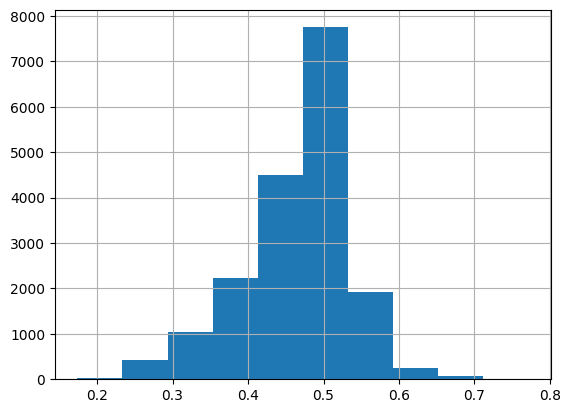

In [78]:
# Normalized Eucledian distances on LiDAR readings 
eucledian_dist = other_set_df['laser_readings'].map(lambda x: np.sqrt(np.sum((anchor_rec.laser_readings['scan'] - x['scan'])**2))/np.sqrt(228))
eucledian_dist.hist();

-5 -5


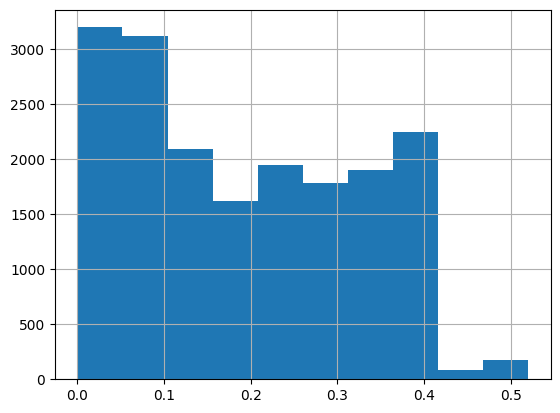

In [79]:
def opposite_corner(x, y):
    opposite_x = -5 if x >= 0 else 5
    opposite_y = -5 if y >= 0 else 5
    return opposite_x, opposite_y

# Normalized goal distance difference 
goal_pos_x, goal_pos_y = anchor_rec['target_point_x'], anchor_rec['target_point_y']
corner_x, corner_y = opposite_corner(goal_pos_x, goal_pos_y)
print(corner_x, corner_y)
max_gd = np.sqrt((goal_pos_x - corner_x)**2 + (goal_pos_y - corner_y)**2)

anchor_gd = np.sqrt((anchor_rec['robot_pos_x'] - goal_pos_x)**2 + (anchor_rec['robot_pos_y'] - goal_pos_y)**2)
gd_diffs = other_set_df.apply(lambda x: abs(anchor_gd - np.sqrt((x['robot_pos_x'] - goal_pos_x)**2 + (x['robot_pos_y'] - goal_pos_y)**2)), axis=1)

gd_diffs = gd_diffs / max_gd
gd_diffs.hist();

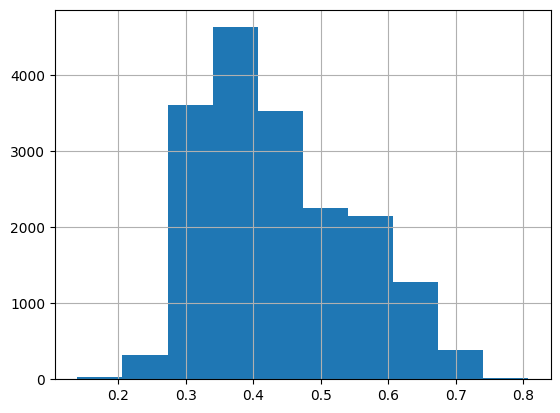

In [80]:
# Combine distances for computing similarities
sim_scores = (1 - eucledian_dist)*(1 - gd_diffs)
sim_scores.hist();

In [81]:
# Negative examples mining
BASE_NEG_DIST = 0.2
N_NEG_SAMPLES = 12

negative = sim_scores[sim_scores < BASE_NEG_DIST]
while negative.shape[0] < N_NEG_SAMPLES*2:
    BASE_NEG_DIST += 0.05
    negative = sim_scores[sim_scores < BASE_NEG_DIST]

neg_ex = negative.sample(n=N_NEG_SAMPLES)
neg_ex

6155     0.249060
11876    0.248010
5386     0.231041
11235    0.205651
11661    0.214893
5248     0.195814
6166     0.244725
6167     0.244589
11666    0.220653
5786     0.143995
6163     0.246712
11665    0.193939
dtype: float64

In [82]:
negative_rec = ep_dfs.iloc[neg_ex.index]
negative_rec

,setting,room,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
6155,7,1,1,12,2.5,0.0,-2.672675,-0.067675,1.011383,-0.714296,...,4.279945,2.300187,True,0.439105,-0.347269,True,"{'scan': [[1.0], [1.0], [0.76289815], [0.74202...",9.0,10.0,11.0
11876,3,2,1,40,2.5,0.0,-3.279558,-0.350048,0.237499,8.593853,...,3.457939,0.234458,True,1.791871,3.456942,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5386,6,1,4,3,2.5,0.0,-2.505043,0.000224,0.618884,-2.740394,...,0.647064,1.250504,False,0.376323,3.519961,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
11235,2,2,5,2,2.5,0.0,-2.476634,0.002573,0.221979,4.071618,...,6.431433,-2.865795,True,8.201983,2.759044,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
11661,2,2,9,2,2.5,0.0,-2.438812,0.001145,0.067476,6.663373,...,-1.680878,2.620583,False,3.127546,3.932259,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5248,6,1,2,3,2.5,0.0,-2.435470,0.012135,0.429727,5.916571,...,4.537904,-2.125854,True,0.617026,0.885174,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
6166,7,1,1,23,2.5,0.0,-2.617353,0.015281,0.953471,-0.660349,...,3.985184,2.476751,True,0.272922,-0.453279,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [0.76754...",9.0,10.0,11.0
6167,7,1,1,24,2.5,0.0,-2.604072,0.034267,0.970659,-0.743088,...,4.016906,2.386933,True,0.238179,-0.459880,False,"{'scan': [[1.0], [1.0], [1.0], [0.7673388], [0...",9.0,10.0,11.0
11666,2,2,9,7,2.5,0.0,-2.252221,0.059069,0.640658,5.997179,...,-0.273304,3.086384,False,4.632158,1.772881,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
5786,6,1,8,1,2.5,0.0,-2.508688,-0.000324,0.075464,6.670064,...,1.679249,-0.436202,True,2.208189,-3.239627,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [83]:
# Retrieve negative records
neg_imgs = []
for _, neg_rec in negative_rec.iterrows():
    neg_room = neg_rec['room']
    neg_set = neg_rec['setting']
    neg_ep = neg_rec['episode']
    neg_step = neg_rec['step']
    neg_imgs.append((f'./datasets/with-augmentations/Room{neg_room}/Setting{neg_set}/episode_{neg_ep:04}/rgb_{neg_step:05}.png', neg_room, neg_set, neg_ep, neg_step))

In [84]:
# Positive examples mining
BASE_POS_DIST = 0.9
N_POS_SAMPLES = 4

positive = sim_scores[sim_scores > BASE_POS_DIST]
while positive.shape[0] < N_POS_SAMPLES*2:
    BASE_POS_DIST -= 0.001
    positive = sim_scores[sim_scores > BASE_POS_DIST]

pos_ex = positive.sample(n=N_POS_SAMPLES)
pos_ex

3905    0.780910
3902    0.793173
5362    0.766766
3608    0.751810
dtype: float64

In [85]:
positive_rec = ep_dfs.iloc[pos_ex.index]
positive_rec

,setting,room,episode,step,target_point_x,target_point_y,robot_pos_x,robot_pos_y,robot_yaw,robot_1_rel_pos_x,...,robot_2_rel_pos_x,robot_2_rel_pos_y,robot_2_in_fov,robot_3_rel_pos_x,robot_3_rel_pos_y,robot_3_in_fov,laser_readings,robot_1_body_id,robot_2_body_id,robot_3_body_id
3905,4,1,7,105,2.5,0.0,1.567253,0.692124,-0.247927,1.908343,...,-2.601533,-4.886295,False,-5.714153,-1.985508,False,"{'scan': [[0.2522062], [0.24766815], [0.243368...",9.0,10.0,11.0
3902,4,1,7,102,2.5,0.0,1.414541,0.727431,-0.206713,1.967307,...,-2.639989,-4.750821,False,-5.642985,-1.743175,False,"{'scan': [[0.2521107], [0.24793145], [0.243967...",9.0,10.0,11.0
5362,6,1,3,93,2.5,0.0,1.267418,0.756805,-0.315618,-3.635508,...,1.344107,-4.728358,False,-4.289575,3.073408,False,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0
3608,4,1,4,102,2.5,0.0,1.487025,0.871702,-0.346407,3.558576,...,5.012789,-5.433561,True,4.185629,-4.687978,True,"{'scan': [[1.0], [1.0], [1.0], [1.0], [1.0], [...",9.0,10.0,11.0


In [86]:
# Retrieve positive records
pos_imgs = []
for _, pos_rec in positive_rec.iterrows():
    pos_room = pos_rec['room']
    pos_set = pos_rec['setting']
    pos_ep = pos_rec['episode']
    pos_step = pos_rec['step']
    pos_imgs.append((f'./datasets/with-augmentations/Room{pos_room}/Setting{pos_set}/episode_{pos_ep:04}/rgb_{pos_step:05}.png', pos_room, pos_set, pos_ep, pos_step))

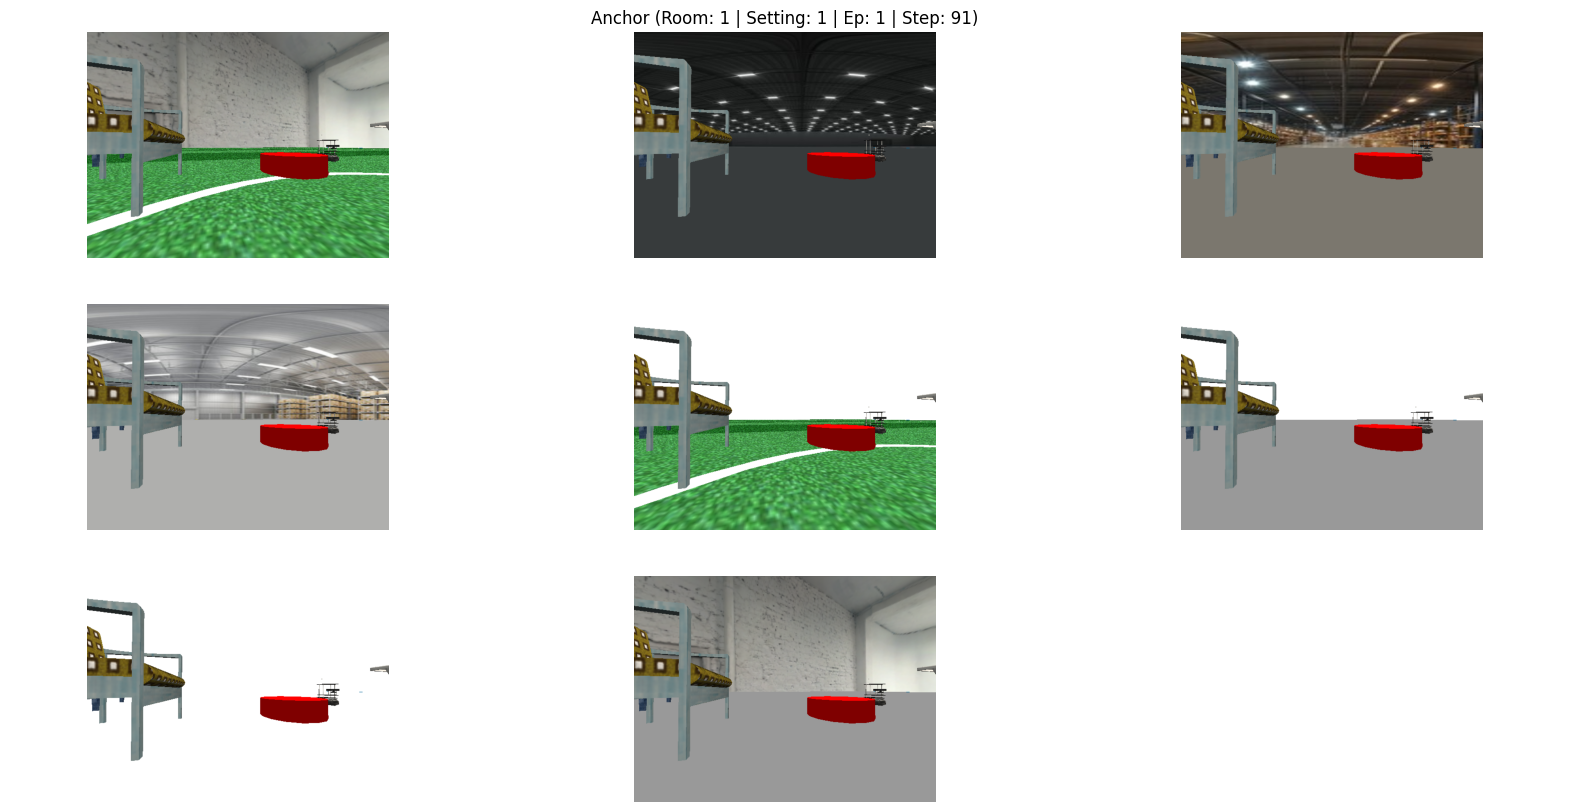

In [87]:
# Anchor image
anc_img = Image.open(f'./datasets/with-augmentations/Room{room}/Setting{setting}/episode_{ep:04}/rgb_{step:05}.png')
# Augmentations
aug_paths = glob(f'./datasets/with-augmentations/Room{room}/Setting{setting}/episode_{ep:04}/augmented_results/*_rgb_{step:05}.png')

# Plot
ROWS = 3
COLS = 3
plt.figure(figsize=[20,10])
plt.title(f'Anchor (Room: {room} | Setting: {setting} | Ep: {ep} | Step: {step})')
plt.axis('off')
plt.subplot(ROWS, COLS, 1)
plt.axis('off')
plt.imshow(anc_img)
for idx, path in enumerate(aug_paths):
    img = Image.open(path)
    plt.subplot(ROWS, COLS, idx+2)
    plt.axis('off')
    plt.imshow(img)

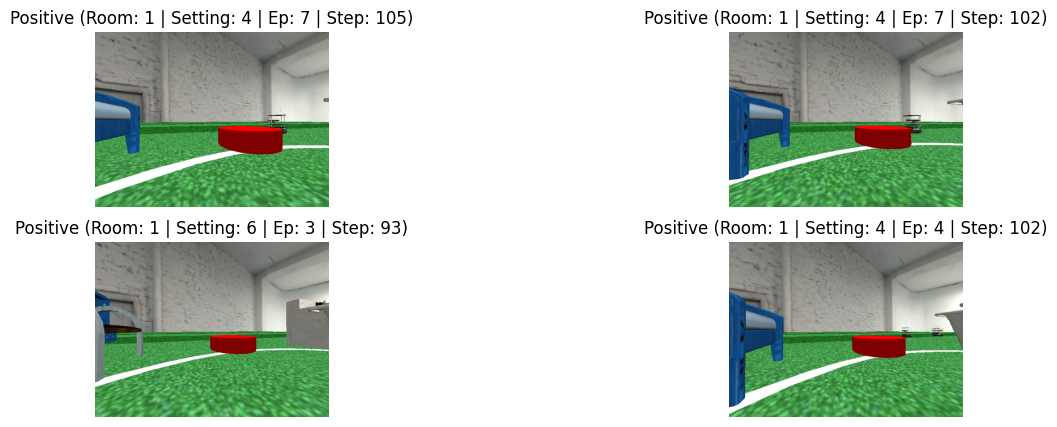

In [88]:
N_ROWS = 2
N_COLS = 2

# Plot positive examples by similarity
plt.figure(figsize=[15,5])
for idx, pos in enumerate(pos_imgs):
    img = Image.open(pos[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Positive (Room: {pos[1]} | Setting: {pos[2]} | Ep: {pos[3]} | Step: {pos[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();

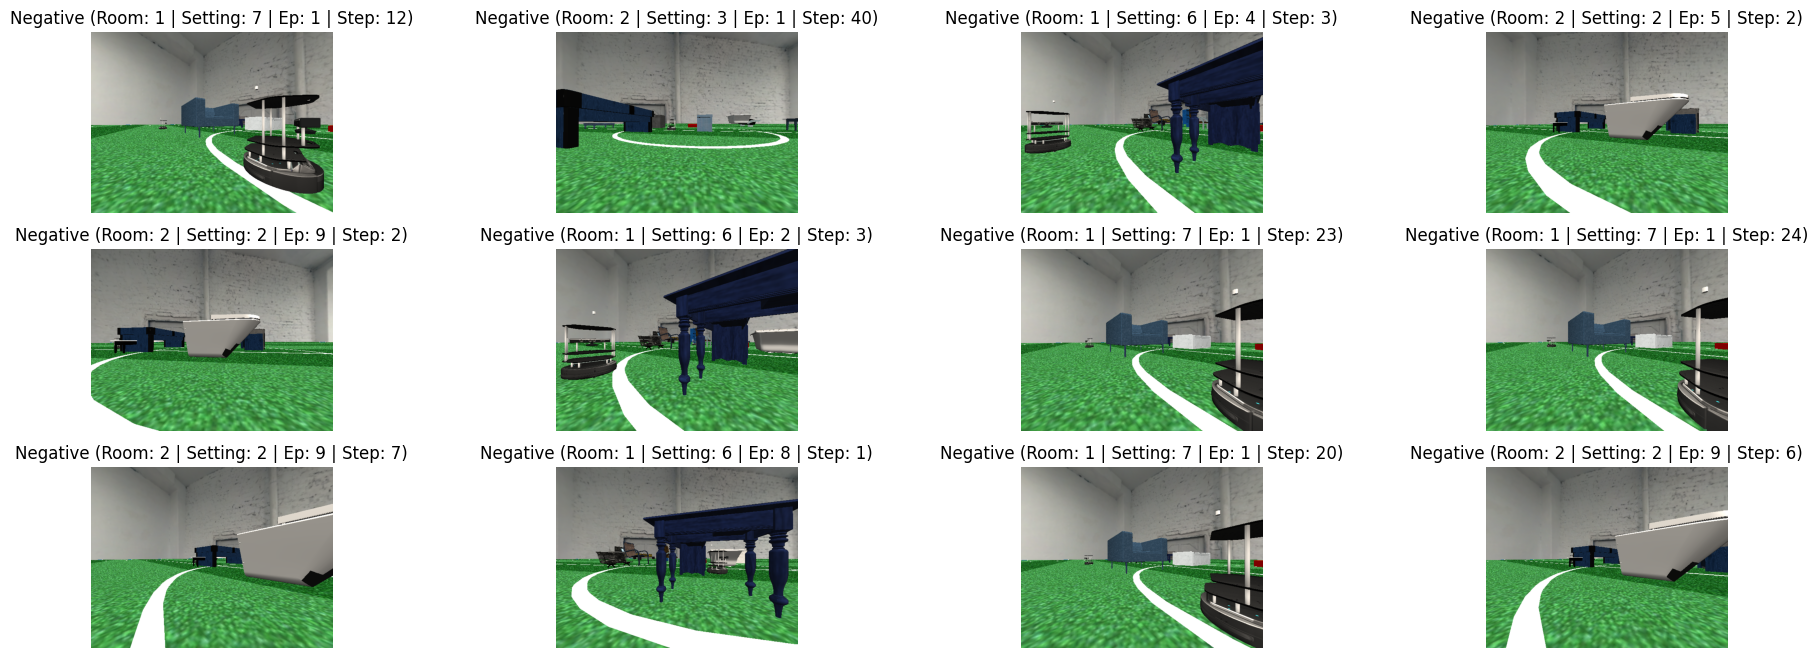

In [89]:
N_ROWS = 3
N_COLS = 4

# Plot negative examples by similarity
plt.figure(figsize=[23,8])
for idx, neg in enumerate(neg_imgs):
    img = Image.open(neg[0])
    plt.subplot(N_ROWS, N_COLS, idx+1)
    plt.title(f'Negative (Room: {neg[1]} | Setting: {neg[2]} | Ep: {neg[3]} | Step: {neg[4]})')
    plt.axis('off')
    plt.imshow(img)
plt.show();